## GPT Classifier
In this pipeline we will classify as relevant or not each element of the test-set

In [ ]:
import json

from dotenv import load_dotenv
import os

os.chdir("..")
os.getcwd()
load_dotenv()

print(os.getcwd())

In [1]:
from datasets import load_dataset

test = load_dataset("Eathus/github-issues-vul-detection", split="test")
test_df = test.to_pandas()

### Comparison between Eathus data and DanCip data

In [ ]:
from datasets import load_dataset

test_dan = load_dataset("DanCip/github-issues-vul-detection", split="test")
test_df_dan = test_dan.to_pandas()

In [ ]:
print("len(test_df_dan):", len(test_df_dan))
print("len(test_df):", len(test_df))

print("Dan posetive count:", len(test_df_dan[test_df_dan['label']]))
print("Eathus posetive count:", len(test_df[test_df['label']]))

## Zero-shot learning

In [ ]:
# Cost only of the input
(test_df.issue_msg_n_tokens.sum() / 1000000) * 0.15

In [2]:
from utils import *
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field


class ReplySchema(BaseModel):
    gpt_description: str = Field(
        description="describe the vulnerability detected if any, otherwise write None"
    )
    gpt_confidence: int = Field(
        description="An integer from 1 to 5 indicating your level of confidence  (1 = very low, 2 = low, 3 = medium, 4 = high, 5 = very high)."
    )
    gpt_is_relevant: bool = Field(
        description="boolean that states if there is a vulnerability"
    )


llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.0)

prompts_dict = load_prompts(os.getcwd() + "/prompts")

prompt = ChatPromptTemplate.from_messages(
    [("system", prompts_dict["system_setup"]), ("human", "{msg}")],
)


def parser(message: ReplySchema):
    return message.model_dump_json()


llm = llm.with_structured_output(ReplySchema)
chain = prompt | llm | parser

In [ ]:
chain.invoke(test_df.issue_msg.sample(1))

In [ ]:
usage = client.usage()
print(f"Remaining: {usage['hard_limit'] - usage['current_usage']}")

In [13]:
from utils import *
from pandarallel import pandarallel
from tenacity import retry, stop_after_attempt, wait_exponential, retry_if_exception_type
from openai import OpenAIError, RateLimitError  # Explicitly import errors

pandarallel.initialize(progress_bar=True, nb_workers=15)

@retry(
    stop=stop_after_attempt(5),  # Retry up to 5 times
    wait=wait_exponential(multiplier=2, min=1, max=60),  # Exponential backoff
    retry=retry_if_exception_type(RateLimitError),  # Retry only on rate limit errors
)
def _gpt_classify(msg):
    if not msg or not isinstance(msg, str):  # Check for empty/invalid messages
        return None
    return chain.invoke({"msg": msg})  # Adjusted for OpenAI API format

def gpt_classify(msg):
    try:
        return _gpt_classify(msg)
    except OpenAIError as e:  # Catch all OpenAI-specific errors
        print(f"OpenAI API error: {e}")
    except Exception as e:
        print(f"General error processing message: {e}")
    return None


INFO: Pandarallel will run on 15 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [1]:
from datasets import load_dataset

test = load_dataset("Eathus/github-issues-vul-detection-gpt-zero-results", split="test")
test_df = test.to_pandas()

README.md:   0%|          | 0.00/7.31k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/35.7M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/1778 [00:00<?, ? examples/s]

In [5]:
import json
import pandas as pd

# Step 1: Combine the normalized columns back into a dictionary
test_df['gpt_response'] = test_df.apply(
    lambda row: json.dumps({
        'gpt_description': row['gpt_description'],
        'gpt_confidence': row['gpt_confidence'],
        'gpt_is_relevant': row['gpt_is_relevant']
    }) if pd.notna(row['gpt_description']) else None,
    axis=1
)

# Step 2: Drop the individual normalized columns (optional)
test_df = test_df.drop(columns=['gpt_description', 'gpt_confidence', 'gpt_is_relevant'])

In [ ]:
len(test_df[test_df.gpt_response.isna()])

In [ ]:
import pickle 
import time

retries = 0
max_retries = 10
file_path = "tmp/gpt_response_zero_df.pkl"
DELAY = 60 
#test_df['gpt_response'] = None
while not test_df[test_df.gpt_response.isna()].empty and retries < max_retries :
    # Get indices of rows needing processing
    na_indices = test_df[test_df.gpt_response.isna()].index
    
    if len(na_indices) == 0:
        break
    
    # Process ONLY those rows and assign directly to original DF
    test_df.loc[na_indices, 'gpt_response'] = \
        test_df.loc[na_indices, 'issue_msg'].parallel_apply(gpt_classify)
    
    with open(file_path, "wb") as file:  # 'wb' mode writes in binary format
        pickle.dump(test_df, file)
    retries += 1
    print(f"Retry {retries}: Processed {len(na_indices)} rows")
    time.sleep(DELAY)

Error processing message after retries: RetryError[<Future at 0x7000082a9910 state=finished raised RateLimitError>]
Error processing message after retries: RetryError[<Future at 0x6fffe872d820 state=finished raised RateLimitError>]
Error processing message after retries: RetryError[<Future at 0x70000dd58ec0 state=finished raised RateLimitError>]
Error processing message after retries: RetryError[<Future at 0x70000beca720 state=finished raised RateLimitError>]
Error processing message after retries: RetryError[<Future at 0x70000bee62a0 state=finished raised RateLimitError>]
Error processing message after retries: RetryError[<Future at 0x6fffe877e3f0 state=finished raised RateLimitError>]
Error processing message after retries: RetryError[<Future at 0x70000bec49e0 state=finished raised RateLimitError>]
Error processing message after retries: RetryError[<Future at 0x70000bed7440 state=finished raised RateLimitError>]
Error processing message after retries: RetryError[<Future at 0x70000bee

Retry 2: Processed 24 rows


In [14]:
print(*test_df.sample(3)['gpt_response'])
display(test_df.sample(3)['gpt_response'])

{"gpt_description":"The issue describes a mismatch in the duration of AdaptationSets when using the MP4Box tool to create a DASH manifest. The user reports that MP4Box throws a warning about unequal durations, which could lead to playback issues. However, the issue does not indicate a security vulnerability; it is more related to functionality and media synchronization rather than a security flaw. The warning about unequal durations is a common issue in media processing and does not expose any sensitive data or allow for exploitation. Therefore, this issue is not relevant to security vulnerabilities.","gpt_confidence":4,"gpt_is_relevant":false} {"gpt_description": "The issue describes a functionality problem with the mp4dump tool where it fails to dump sample data from fragmented mp4 files. The user has identified a potential solution and is seeking feedback on their patch. This issue does not indicate a security vulnerability, as it pertains to the functionality of the tool rather tha

1206    {"gpt_description": "The issue describes a cra...
783     {"gpt_description":"The issue describes multip...
1685    {"gpt_description":"The issue describes an inv...
Name: gpt_response, dtype: object

In [24]:
len(test_df[~test_df.gpt_confidence.isna()])

1778

In [16]:
import json
import pandas as pd

test_df['gpt_response'] = test_df['gpt_response'].map(
    lambda x: json.loads(x) if pd.notna(x) else None
)

In [17]:
print(*test_df.sample(3)['gpt_response'])
display(type(test_df['gpt_response'][0]))

{'gpt_description': 'The issue describes a segmentation fault (SEGV) that occurs when executing a JavaScript file with a specific payload using the MJS interpreter. The AddressSanitizer report indicates that the fault is due to a read memory access violation, which suggests that the code is attempting to access an invalid memory location. This could potentially be exploited to execute arbitrary code or cause a denial of service, indicating a security vulnerability. The use of `Object.create` with an invalid index in the payload is likely triggering this fault, which is a common pattern in security vulnerabilities related to memory management.', 'gpt_confidence': 4.0, 'gpt_is_relevant': True} {'gpt_description': 'The issue describes a problem with the MP4Box tool failing to split a large video file into segments, resulting in incomplete output. This appears to be a functionality issue rather than a security vulnerability, as it does not indicate any unauthorized access, data leakage, or

dict

In [18]:
import pandas as pd

tmp = pd.json_normalize(test_df["gpt_response"])
test_df = pd.concat([test_df.drop(columns=["gpt_response"]), tmp], axis=1)

In [19]:
vul_dscrpt_df = test_df[~test_df['gpt_is_relevant'].isna() & test_df['gpt_is_relevant']][['gpt_description']]
print(len(vul_dscrpt_df))
display(*vul_dscrpt_df.sample(3)['gpt_description'])

587


'The issue describes a security vulnerability (CVE-2023-3955) in Kubernetes that allows users with the ability to create pods on Windows nodes to escalate their privileges to admin level. This is due to insufficient input sanitization, which poses a significant risk to Kubernetes environments that include Windows nodes. The CVSS rating of 8.8 indicates a high severity, and the issue is confirmed to affect specific versions of kubelet. The provided mitigation steps and fixed versions further validate the presence of a serious security vulnerability.'

'The issue describes a buffer overflow vulnerability in the function `avc_parse_slice` located in `media_tools/av_parsers.c` at line 5684. The reported runtime error indicates that an index is being accessed that exceeds the bounds of an array, specifically `AVC_SPS [32]`, which suggests that the code is attempting to read or write beyond the allocated memory for this array. This type of vulnerability can lead to undefined behavior, crashes, or potential exploitation by an attacker to execute arbitrary code. Given the nature of the error and the context provided, this is a clear indication of a security vulnerability.'

'The issue describes a stack buffer overflow vulnerability in the ImageMagick library, specifically in the function ReadXPMImage located in the file xpm.c. The provided AddressSanitizer (ASAN) log indicates that there is an attempt to read memory beyond the allocated stack space, which can lead to undefined behavior, crashes, or potential exploitation by an attacker. This type of vulnerability is critical as it can be exploited to execute arbitrary code or cause a denial of service. Given the details and the nature of the error, this is a confirmed security vulnerability.'

In [25]:
from datasets import Dataset

# test
ds = Dataset.from_pandas(test_df)
ds.push_to_hub("Eathus/github-issues-vul-detection-gpt-zero-results", split="test")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/Eathus/github-issues-vul-detection-gpt-zero-results/commit/4b13e80f1070ba55ebbfe7d1122b179a643929f5', commit_message='Upload dataset', commit_description='', oid='4b13e80f1070ba55ebbfe7d1122b179a643929f5', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/Eathus/github-issues-vul-detection-gpt-zero-results', endpoint='https://huggingface.co', repo_type='dataset', repo_id='Eathus/github-issues-vul-detection-gpt-zero-results'), pr_revision=None, pr_num=None)

In [2]:
test_df[
    test_df.gpt_confidence == 5
].gpt_is_relevant.sum(), test_df.gpt_is_relevant.count()

(np.int64(328), np.int64(1778))

In [3]:
from sklearn.metrics import accuracy_score, classification_report

y_test = test_df.label.values
y_pred = test_df.gpt_is_relevant.values

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.813273340832396
Classification Report:
              precision    recall  f1-score   support

       False       0.97      0.79      0.87      1457
        True       0.49      0.90      0.63       321

    accuracy                           0.81      1778
   macro avg       0.73      0.85      0.75      1778
weighted avg       0.89      0.81      0.83      1778



## Few-shot learning

In [ ]:
from datasets import load_dataset

test = load_dataset("Eathus/github-issues-vul-detection", split="test")
test_df = test.to_pandas()

In [ ]:
# Cost only of the input
(test_df.issue_msg_n_tokens.sum() / 1000000) * 0.15

In [ ]:
from utils import *
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field


class ReplySchema(BaseModel):
    gpt_description: str = Field(
        description="describe the vulnerability detected if any, otherwise write None"
    )
    gpt_confidence: int = Field(
        description="An integer from 1 to 5 indicating your level of confidence  (1 = very low, 2 = low, 3 = medium, 4 = high, 5 = very high)."
    )
    gpt_is_relevant: bool = Field(
        description="boolean that states if there is a vulnerability"
    )


llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.0)

prompts_dict = load_prompts(os.getcwd() + "/prompts")

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", prompts_dict["system_setup"]),
        (
            "human",
            """
    This is a GitHub Issue\nrepo: ZipArchive\nowner: ZipArchive\nTitle : Unhandled edge case in _sanitizedPath #680 \n\n--- start body ---\nDescription:\n\nThere is an unhandeled edge case where we can crash the application when it tries to unzip a specially crafted zip file\n\nTechnical details:\n\nBelow is a code snippet from the _sanitizedPath function used to sanitize file paths coming from zip entries before extraction to prevent path traversal, the function prepends file:/// to the provided path, standardizes it using NSURL and then removes the prepended file:///, when provided with the following path however /.., the standardized path returned by NSURL becomes file://, which has 7 characters, the package however expects at least 8 characters (length of the prepended text), this results in crashing the application.\n\n// Add scheme \"file:///\" to support sanitation on names with a colon like \"file:a/../../../usr/bin\"\nstrPath = [@\"file:///\" stringByAppendingString:strPath];\n\n// Sanitize path traversal characters to prevent directory backtracking. Ignoring these characters mimicks the default behavior of the Unarchiving tool on macOS.\n// \"../../../../../../../../../../../tmp/test.txt\" -> \"tmp/test.txt\"\n// \"a/b/../c.txt\" -> \"a/c.txt\"\nstrPath = [NSURL URLWithString:strPath].standardizedURL.absoluteString;\n\n// Remove the \"file:///\" scheme\nstrPath = [strPath substringFromIndex:8];\nPoC:\n\nimport zipfile\n\ndef compress_file(filename):\n    with zipfile.ZipFile('payload.zip', 'w') as zipf:\n        zipf.writestr(filename, \"Test payload\")\n\nfilename = '/..'\n\ncompress_file(filename)\n--- end body ---
    """,
        ),
        (
            "ai",
            """
     \"gpt_description\": \"An unhandled edge case in the component _sanitizedPath of ZipArchive v2.5.4 allows attackers to cause a Denial of Service (DoS) via a crafted zip file.\" \"gpt_confidence\": 5, \"gpt_is_relevant\": true
    """,
        ),
        (
            "human",
            """
    This is a GitHub Issue\nrepo:MonetDB\nowner:MonetDB\nTitle : MonetDB server 11.46.0 crashes at list_append #7383\n\nIssue date:\n\n--- start body ---\nDescribe the bug\nMonetDB server 11.46.0 crashes at list_append after executing SQL statements through mclient.\n\nTo Reproduce\n\ncreate table t1(c1 int auto_increment primary key NOT NULL);\ncreate trigger i1 after insert on t1 for each row insert into t1 values(NULL);\ninsert into t1 values(NULL);\nExpected behavior\nThis crash is strange. From the backtrace as follows, we can know that the crash is caused by infinite recursion.\n\nHowever, if we change the first statement into create table t1(c1 int);, the MonetDB will return the message Query too complex: running out of stack space when executing the third stmt. So, MonetDB handles out of stack space, but it does not work with some special table definitions?\n\nWhat's more, the definition of the table contains the NOT NULL constraint, which should fail the third stmt. If we remove the create trigger statement, MonetDB will return the message INSERT INTO: NOT NULL constraint violated for column t1.c1 when executing the insert stmt. But with the create trigger stmt, it crashes instead.\n\nAnyway, I think the expected behavior is to return the error message Query too complex: running out of stack space or INSERT INTO: NOT NULL constraint violated for column t1.c1, instead of crashing straightly.\n\nBacktrace\n\n#0 0x7f0c3760dbda (list_append+0x1a)\n#1 0x7f0c376669c6 (rel_insert+0x196)\n#2 0x7f0c3766abb3 (rel_updates+0x1ce3)\n#3 0x7f0c376c6c11 (sequential_block+0x121)\n#4 0x7f0c376c52dc (rel_psm+0x131c)\n#5 0x7f0c37653091 (rel_semantic+0x91)\n#6 0x7f0c37652e6a (rel_parse+0x19a)\n#7 0x7f0c37563102 (sql_insert_triggers+0x232)\n#8 0x7f0c3755bb5e (rel2bin_insert+0x148e)\n#9 0x7f0c37554539 (subrel_bin+0xd69)\n#10 0x7f0c3755f218 (exp_bin+0x29e8)\n#11 0x7f0c37558567 (subrel_bin+0x4d97)\n#12 0x7f0c37563162 (sql_insert_triggers+0x292)\n#13 0x7f0c3755bb5e (rel2bin_insert+0x148e)\n#14 0x7f0c37554539 (subrel_bin+0xd69)\n#15 0x7f0c3755f218 (exp_bin+0x29e8)\n#16 0x7f0c37558567 (subrel_bin+0x4d97)\n#17 0x7f0c37563162 (sql_insert_triggers+0x292)\n...\n#7407 0x7f0c37563162 (sql_insert_triggers+0x292)\n#7408 0x7f0c3755bb5e (rel2bin_insert+0x148e)\n#7409 0x7f0c37554539 (subrel_bin+0xd69)\n#7410 0x7f0c3755373b (output_rel_bin+0x6b)\n#7411 0x7f0c3757f9d9 (backend_dumpstmt+0x199)\n#7412 0x7f0c3754a367 (SQLparser+0x5d7)\n#7413 0x7f0c3754987b (SQLengine_+0x59b)\n#7414 0x7f0c37548343 (SQLengine+0x23)\n#7415 0x7f0c378d76cf (runScenario+0x4f)\n#7416 0x7f0c378d816c (MSscheduleClient+0x68c)\n#7417 0x7f0c3797fc2b (doChallenge+0xfb)\n#7418 0x7f0c37ffeba0 (THRstarter+0x100)\n#7419 0x7f0c3806ecc4 (thread_starter+0x34)\n#7420 0x7f0c373e3609 (start_thread+0xd9)\n#7421 0x7f0c37308133 (clone+0x43)\nSoftware versions\n\nMonetDB server version: 11.46.0 (hg id: 63a42c2) (pulled from the master branch)\nMonetDB client version: mclient, version 11.48.0 (hg id: 63a42c2)\nOS and version: ubuntu 20.04\nSelf-installed and compiled. The command line of compilation: CC=clang-12 CXX=clang++-12 cmake /root/monetdb_master -DCMAKE_BUILD_TYPE=RelWithDebInfo\nIssue labeling\nbug\n\nAdditional context\nThe MonetDB here runs in-memory database. The command line of starting MonetDB server is mserver5 --in-memory.\n--- end body ---\n
    """,
        ),
        (
            "ai",
            """
    \"gpt_description\": \"An issue in the list_append component of MonetDB Server v11.45.17 and v11.46.0 allows attackers to cause a Denial of Service (DoS) via crafted SQL statements.\", \"gpt_confidence\": 5,\n    \"gpt_is_relevant\": true
    """,
        ),
        (
            "human",
            """
    This is a GitHub Issue repo:libredwg owner:LibreDWG Title : Segmentation fault in acds_private Issue date: --- start body --- [2.zip](https://github.com/LibreDWG/libredwg/files/11244857/2.zip) ``` (gdb) (gdb) r -v9 /home/user/out/default/crashes/2* The program being debugged has been started already. Start it from the beginning? (y or n) y Starting program: /home/user/libredwg/dwgread -v9 /home/user/out/default/crashes/2* Reading DWG file /home/user/out/default/crashes/2.dwg Program received signal SIGSEGV, Segmentation fault. 0xb6c8eb26 in acds_private (dat=0xbfffe330, dwg=0xbfffe578) at src/acds.spec:215 215 SUB_FIELD_RL (schidx.props[rcount2],index, 0); (gdb) ``` --- end body ---
    """,
        ),
        (
            "ai",
            """
    \"gpt_description\": \"\", \"gpt_confidence\": 2,\n    \"gpt_is_relevant\": false
    """,
        ),
        ("human", "{msg}"),
    ]
)


def parser(message: ReplySchema):
    return message.model_dump_json()


llm = llm.with_structured_output(ReplySchema)
chain = prompt | llm | parser

In [ ]:
chain.invoke(test_df.issue_msg.sample(1).values[0])

In [27]:
from utils import *
from pandarallel import pandarallel
from tenacity import retry, stop_after_attempt, wait_exponential, retry_if_exception_type
from openai import OpenAIError, RateLimitError  # Explicitly import errors

pandarallel.initialize(progress_bar=True, nb_workers=15)

@retry(
    stop=stop_after_attempt(5),  # Retry up to 5 times
    wait=wait_exponential(multiplier=2, min=1, max=60),  # Exponential backoff
    retry=retry_if_exception_type(RateLimitError),  # Retry only on rate limit errors
)
def _gpt_classify(msg):
    if not msg or not isinstance(msg, str):  # Check for empty/invalid messages
        return None
    return chain.invoke({"msg": msg})  # Adjusted for OpenAI API format

def gpt_classify(msg):
    try:
        return _gpt_classify(msg)
    except OpenAIError as e:  # Catch all OpenAI-specific errors
        print(f"OpenAI API error: {e}")
    except Exception as e:
        print(f"General error processing message: {e}")
    return None


INFO: Pandarallel will run on 15 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [28]:
from datasets import load_dataset

test = load_dataset("Eathus/github-issues-vul-detection-gpt-few-results", split="test")
test_df = test.to_pandas()

README.md:   0%|          | 0.00/7.31k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/35.3M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/1778 [00:00<?, ? examples/s]

In [29]:
import json
import pandas as pd

# Step 1: Combine the normalized columns back into a dictionary
test_df['gpt_response'] = test_df.apply(
    lambda row: json.dumps({
        'gpt_description': row['gpt_description'],
        'gpt_confidence': row['gpt_confidence'],
        'gpt_is_relevant': row['gpt_is_relevant']
    }) if pd.notna(row['gpt_description']) else None,
    axis=1
)

# Step 2: Drop the individual normalized columns (optional)
test_df = test_df.drop(columns=['gpt_description', 'gpt_confidence', 'gpt_is_relevant'])

In [30]:
len(test_df[test_df.gpt_response.isna()])

1586

In [ ]:
import pickle 
import time

retries = 0
max_retries = 10
file_path = "tmp/gpt_response_few_df.pkl"
DELAY = 60 
#test_df['gpt_response'] = None
while not test_df[test_df.gpt_response.isna()].empty and retries < max_retries :
    # Get indices of rows needing processing
    na_indices = test_df[test_df.gpt_response.isna()].index
    
    if len(na_indices) == 0:
        break
    
    # Process ONLY those rows and assign directly to original DF
    test_df.loc[na_indices, 'gpt_response'] = \
        test_df.loc[na_indices, 'issue_msg'].parallel_apply(gpt_classify)
    
    with open(file_path, "wb") as file:  # 'wb' mode writes in binary format
        pickle.dump(test_df, file)
    retries += 1
    print(f"Retry {retries}: Processed {len(na_indices)} rows")
    time.sleep(DELAY)

General error processing message: RetryError[<Future at 0x7000d8c71910 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x7000d898cd40 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x70000bed4170 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x7000d8c70a70 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x6fffe8743770 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x7000d8929820 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x7000d89b5cd0 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x7000d8c700b0 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x7000d89c88c0 state=finished raised RateLimitError>]
General er

General error processing message: RetryError[<Future at 0x6fffe891bfb0 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x7000d8929a60 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x7000d8948860 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x7000d8949340 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x6fffe872fad0 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x7000d8940050 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x6fffe88ac290 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x6fffe88ac110 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x7000d8c69460 state=finished raised RateLimitError>]
General er

General error processing message: RetryError[<Future at 0x7000d893a360 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x70000bebc770 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x7000d8c8e120 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x7000d8903fb0 state=finished raised RateLimitError>]General error processing message: RetryError[<Future at 0x7000d8c6a4e0 state=finished raised RateLimitError>]

General error processing message: RetryError[<Future at 0x7000d89026c0 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x7000001363c0 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x7000e454c1d0 state=finished raised RateLimitError>]General error processing message: RetryError[<Future at 0x6fffe88ac2c0 state=finished raised RateLimitError>]

General er

General error processing message: RetryError[<Future at 0x6fffe8741520 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x7000d85ce750 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x6fffe872fad0 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x70000dd5a210 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x7000d8c696a0 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x6fffe8daeff0 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x7000d8956fc0 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x70000dcf2600 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x7000c0e8bd40 state=finished raised RateLimitError>]
General er

General error processing message: RetryError[<Future at 0x6fffe8de8fb0 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x7000d8967aa0 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x70006cf1ae70 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x6fffe8994c50 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x70000dcf2960 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x6fffe872d760 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x7000d8c6be60 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x7000d85ce4b0 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x7000d890ea80 state=finished raised RateLimitError>]
General er

General error processing message: RetryError[<Future at 0x7000d8c73620 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x6ffff4294650 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x7000d898e750 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x6fffe92aacf0 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x6fffe87304d0 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x7000d894a9f0 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x6fffe88f6fc0 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x70000874e6f0 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x7000d89330b0 state=finished raised RateLimitError>]
General er

Retry 7: Processed 13 rows


In [32]:
test_df.sample(3)

,cve_id,cve_published,cve_descriptions,cve_metrics,cve_references,cve_configurations,cve_primary_cwe,cve_tags,issue_owner_repo,issue_body,...,issue_updated_at,issue_html_url,issue_github_id,issue_number,label,issue_msg,issue_msg_n_tokens,issue_embedding,__index_level_0__,gpt_response
685,CVE-2019-20011,2019-12-27T01:15:13.383,An issue was discovered in GNU LibreDWG 0.92. ...,"{'cvssMetricV2': [{'acInsufInfo': False, 'base...","[{'source': 'cve@mitre.org', 'tags': ['Mailing...",[{'nodes': [{'cpeMatch': array([{'criteria': '...,125,"[Exploit, Issue Tracking, Third Party Advisory]","[LibreDWG, libredwg]","Hi,\r\nAfter fuzzing libredwg, I found the fol...",...,2020-01-16T12:12:03Z,https://github.com/LibreDWG/libredwg/issues/176,541977765,176,True,This is a GitHub Issue\nrepo:libredwg\nowner:L...,5103,"[-0.04038931429386139, 0.03147762641310692, -0...",107,"{""gpt_description"":""The issue describes a vuln..."
605,None,None,None,None,None,None,No_CWE,None,"[gpac, gpac]",According to https://sonix.ai/resources/what-i...,...,2025-02-07T17:39:53Z,https://github.com/gpac/gpac/issues/3080,2780703740,3080,False,This is a GitHub Issue\nrepo:gpac\nowner:gpac\...,623,"[-0.010362740606069565, 0.014910629019141197, ...",929,"{""gpt_description"": ""The issue discusses a for..."
1387,CVE-2021-46089,2022-01-25T15:15:08.203,"In JeecgBoot 3.0, there is a SQL injection vul...","{'cvssMetricV2': [{'acInsufInfo': False, 'base...","[{'source': 'cve@mitre.org', 'tags': ['Exploit...",[{'nodes': [{'cpeMatch': array([{'criteria': '...,89,"[Exploit, Issue Tracking, Third Party Advisory]","[jeecgboot, jeecg-boot]",##### version: <=3.0\r\n\r\n\r\n##### precondi...,...,2022-01-21T02:04:30Z,https://github.com/jeecgboot/JeecgBoot/issues/...,1090357318,3331,True,This is a GitHub Issue\nrepo:jeecg-boot\nowner...,1405,"[-0.0008211372187361121, -0.028606172651052475...",423,"{""gpt_description"":""The issue describes a SQL ..."


In [34]:
len(test_df[~test_df.gpt_response.isna()])

1778

In [35]:
import json
import pandas as pd

test_df['gpt_response'] = test_df['gpt_response'].map(
    lambda x: json.loads(x) if pd.notna(x) else None
)

In [36]:
import pandas as pd

tmp = pd.json_normalize(test_df["gpt_response"])
test_df = pd.concat([test_df.drop(columns=["gpt_response"]), tmp], axis=1)

In [37]:
test_df.sample(1)

,cve_id,cve_published,cve_descriptions,cve_metrics,cve_references,cve_configurations,cve_primary_cwe,cve_tags,issue_owner_repo,issue_body,...,issue_github_id,issue_number,label,issue_msg,issue_msg_n_tokens,issue_embedding,__index_level_0__,gpt_description,gpt_confidence,gpt_is_relevant
780,None,None,None,None,None,None,No_CWE,None,"[LibreDWG, libredwg]",In file included from decode.c:287:0:\r\ntempl...,...,2363394768,987,False,This is a GitHub Issue\nrepo:libredwg\nowner:L...,1022,"[-0.02990289032459259, 0.005507681984454393, -...",2923,The issue describes compilation errors related...,4.0,False


In [38]:
from datasets import Dataset

# test
ds = Dataset.from_pandas(test_df)
ds.push_to_hub("Eathus/github-issues-vul-detection-gpt-few-results", split="test")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/Eathus/github-issues-vul-detection-gpt-few-results/commit/ea6eeb61851eb20e034d3d5edde7020cd8803a3b', commit_message='Upload dataset', commit_description='', oid='ea6eeb61851eb20e034d3d5edde7020cd8803a3b', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/Eathus/github-issues-vul-detection-gpt-few-results', endpoint='https://huggingface.co', repo_type='dataset', repo_id='Eathus/github-issues-vul-detection-gpt-few-results'), pr_revision=None, pr_num=None)

In [39]:
test_df[~test_df.issue_msg.isna()]

,cve_id,cve_published,cve_descriptions,cve_metrics,cve_references,cve_configurations,cve_primary_cwe,cve_tags,issue_owner_repo,issue_body,...,issue_github_id,issue_number,label,issue_msg,issue_msg_n_tokens,issue_embedding,__index_level_0__,gpt_description,gpt_confidence,gpt_is_relevant
0,None,None,None,None,None,None,No_CWE,None,"[llvm, llvm-project]",I don't think we are using `std::memcmp` in `l...,...,2888101422,129325,False,This is a GitHub Issue\nrepo:llvm-project\nown...,297,"[0.0001077328051906079, 0.0041412957943975925,...",4464,The issue discusses the optimization of the `s...,5.0,False
1,None,None,None,None,None,None,No_CWE,None,"[cesanta, mjs]",# s2o\r\n## Environment\r\nUbuntu 22.04.3 LTS\...,...,2269395062,281,False,This is a GitHub Issue\nrepo:mjs\nowner:cesant...,1673,"[-0.01231892965734005, -0.0185470562428236, 0....",3444,The issue describes a segmentation fault (SEGV...,5.0,True
2,None,None,None,None,None,None,No_CWE,None,"[xuxueli, xxl-job]",1. 提供创建、修改、查询、删除任务的openapi，带页面支持签名验签\n2. app启动...,...,2811008852,3641,False,This is a GitHub Issue\nrepo:xxl-job\nowner:xu...,181,"[0.02733539044857025, -0.015366464853286743, -...",4204,The issue describes a feature request for addi...,1.0,False
3,None,None,None,None,None,None,No_CWE,None,"[gpac, gpac]","Excuse me, I want to ask how to call [session....",...,1328199787,2241,False,This is a GitHub Issue\nrepo:gpac\nowner:gpac\...,391,"[-0.036246322095394135, 0.033608801662921906, ...",1513,The issue is a request for guidance on how to ...,1.0,False
4,CVE-2021-39528,2021-09-20T16:15:12.077,An issue was discovered in libredwg through v0...,"{'cvssMetricV2': [{'acInsufInfo': False, 'base...","[{'source': 'cve@mitre.org', 'tags': ['Exploit...",[{'nodes': [{'cpeMatch': array([{'criteria': '...,415,"[Exploit, Issue Tracking, Patch, Third Party A...","[LibreDWG, libredwg]","## System info\r\n\r\nUbuntu X64, gcc (Ubuntu ...",...,670848928,256,True,This is a GitHub Issue\nrepo:libredwg\nowner:L...,2400,"[-0.03039676696062088, 0.01844700239598751, -0...",308,The issue describes a double free vulnerabilit...,5.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1773,CVE-2020-28849,2023-08-11T14:15:11.237,Cross Site Scripting (XSS) vulnerability in Ch...,"{'cvssMetricV2': None, 'cvssMetricV30': None, ...","[{'source': 'cve@mitre.org', 'tags': ['Exploit...",[{'nodes': [{'cpeMatch': array([{'criteria': '...,79,"[Exploit, Issue Tracking]","[ChurchCRM, CRM]",**Name:** Stored Cross Site Scripting leading ...,...,732315548,5477,True,This is a GitHub Issue\nrepo:CRM\nowner:Church...,2220,"[-0.031340837478637695, 0.02009483240544796, -...",771,The issue describes a Stored Cross Site Script...,5.0,True
1774,None,None,None,None,None,None,No_CWE,None,"[axiomatic-systems, Bento4]","Hello, I used the fuzz testing tool to test mp...",...,2214651046,946,False,This is a GitHub Issue\nrepo:Bento4\nowner:axi...,3478,"[-0.034585434943437576, 0.014222408644855022, ...",1954,The issue describes a floating-point exception...,5.0,True
1775,None,None,None,None,None,None,No_CWE,None,"[Piwigo, Piwigo]","<img width=""340"" alt=""Screenshot 2024-11-06 at...",...,2637534626,2267,False,This is a GitHub Issue\nrepo:Piwigo\nowner:Piw...,329,"[-0.04034952446818352, 0.010252232663333416, -...",3808,The issue describes a broken display character...,5.0,False
1776,None,None,None,None,None,None,No_CWE,None,"[LibreDWG, libredwg]",one of the last asan trips without fuzzing.\r\...,...,2060973518,911,False,This is a GitHub Issue\nrepo:libredwg\nowner:L...,288,"[-0.025512749329209328, 0.03568996861577034, -...",2964,The issue indicates a heap-buffer-overflow vul...,4.0,True


## Results

In [40]:
test_df[
    test_df.gpt_confidence == 5
].gpt_is_relevant.sum(), test_df.gpt_is_relevant.count()

(np.int64(457), np.int64(1778))

In [41]:
from sklearn.metrics import accuracy_score, classification_report

y_test = test_df.label.values
y_pred = test_df.gpt_is_relevant.values

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.8160854893138357
Classification Report:
              precision    recall  f1-score   support

       False       0.98      0.79      0.88      1457
        True       0.50      0.93      0.65       321

    accuracy                           0.82      1778
   macro avg       0.74      0.86      0.76      1778
weighted avg       0.89      0.82      0.83      1778



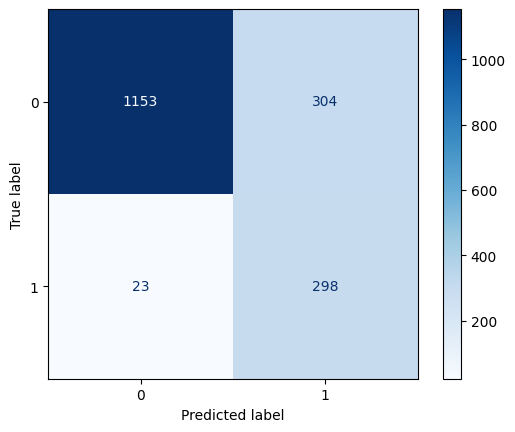

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap="Blues")

In [43]:
test_df.gpt_confidence.describe()

count    1778.000000
mean        3.760405
std         1.187994
min         1.000000
25%         3.000000
50%         4.000000
75%         5.000000
max         5.000000
Name: gpt_confidence, dtype: float64